# SageMaker Serverless Inference 

Amazon SageMaker Serverless Inference is a purpose-built inference option that makes it easy to deploy and scale ML models. 

Serverless Inference is ideal for workloads which have **idle periods** between traffic peaks and can tolerate **cold starts**. Serverless endpoints also automatically launch compute resources and scale them in and out depending on traffic, eliminating the need to choose instance types or manage scaling policies. THis is ideal for scenarios that we have constrains in cost and at the same time we have no idea about the type of instance we need.

For this notebook we'll be working with the **SageMaker XGBoost Algorithm** to train a model and then deploy a serverless endpoint. We will be using the public S3 Abalone regression dataset for this example.

In [1]:
! pip install sagemaker botocore boto3 awscli --upgrade

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.5/684.5 kB 4.0 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 54.7 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.5/135.5 kB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 70.3 MB/s eta 0:00:00ta 0:00:01
  Created wheel for sagemaker: filename=sagemaker-2.140.1-py2.py3-none-any.whl size=925381 sha256=ba7570ac2d4f8590511aca2fc6ba94c9659e6c2fc40b9d23a8f4bfe19669641f
  Stored in directory: /home/ec2-user/.cache/pip/wheels/07/c7/c3/740c46cd3408fdc0f9439aa5cff410e6ad3e1bc298dcf9f9dd
Successfully built sagemaker
  Attempting uninstall: botocore
    Found existing installation: botocore 1.29.71
    Uninstalling botocore-1.29.71:
      Successfully uninstalled botocore-1.29.71
  Attempting uninstall: boto3
    Found existing in

In [2]:
# Setup clients
import boto3

client = boto3.client(service_name="sagemaker")
runtime = boto3.client(service_name="sagemaker-runtime")

To begin, we import the AWS SDK for Python (Boto3) and set up our environment, including an IAM role and an S3 bucket to store our data.

In [9]:
import boto3
import sagemaker
from sagemaker.estimator import Estimator

boto_session = boto3.session.Session()
region = boto_session.region_name
print(region)

sagemaker_session = sagemaker.Session()
base_job_prefix = "xgboost-example"
role = sagemaker.get_execution_role()
print(role)

default_bucket = 'day-07-nr'
s3_prefix = base_job_prefix

training_instance_type = "ml.m5.xlarge"

ca-central-1
arn:aws:iam::224670572127:role/fast-ai-academic-12-Student-Azure


Retrieve the Abalone dataset from a publicly hosted S3 bucket.

In [10]:
# retrieve data
! curl https://sagemaker-sample-files.s3.amazonaws.com/datasets/tabular/uci_abalone/train_csv/abalone_dataset1_train.csv > abalone_dataset1_train.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  131k  100  131k    0     0   333k      0 --:--:-- --:--:-- --:--:--  333k


Upload the Abalone dataset to the default S3 bucket.

In [11]:
# upload data to S3
!aws s3 cp abalone_dataset1_train.csv s3://{default_bucket}/xgboost-regression/train.csv

upload: ./abalone_dataset1_train.csv to s3://day-07-nr/xgboost-regression/train.csv


### Model Training

Now, we train an ML model using the XGBoost Algorithm. In this example, we use a SageMaker-provided XGBoost container image and configure an estimator to train our model.

In [12]:
from sagemaker.inputs import TrainingInput

training_path = f"s3://{default_bucket}/xgboost-regression/train.csv"
train_input = TrainingInput(training_path, content_type="text/csv")

In [13]:
model_path = f"s3://{default_bucket}/{s3_prefix}/xgb_model"

# retrieve xgboost image
image_uri = sagemaker.image_uris.retrieve(
    framework="xgboost",
    region=region,
    version="1.0-1",
    py_version="py3",
    instance_type=training_instance_type,
)

# Configure Training Estimator
xgb_train = Estimator(
    image_uri=image_uri,
    instance_type=training_instance_type,
    instance_count=1,
    output_path=model_path,
    sagemaker_session=sagemaker_session,
    role=role,
)

# Set Hyperparameters
xgb_train.set_hyperparameters(
    objective="reg:linear",
    num_round=50,
    max_depth=5,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.7,
    silent=0,
)

Train the model on the Abalone dataset.

In [14]:
# Fit model
xgb_train.fit({"train": train_input})

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2023-03-22-23-32-02-317


2023-03-22 23:32:05 Starting - Starting the training job...
2023-03-22 23:32:19 Starting - Preparing the instances for training...
2023-03-22 23:32:56 Downloading - Downloading input data...
2023-03-22 23:33:31 Training - Downloading the training image...
2023-03-22 23:34:13 Uploading - Uploading generated training model
2023-03-22 23:34:13 Completed - Training job completed
[2023-03-22 23:33:58.050 ip-10-0-99-102.ca-central-1.compute.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:linear to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Single node training.
[

### Deployment

After training the model, retrieve the model artifacts so that we can deploy the model to an endpoint.

In [15]:
# Retrieve model data from training job
model_artifacts = xgb_train.model_data
model_artifacts

's3://day-07-nr/xgboost-example/xgb_model/sagemaker-xgboost-2023-03-22-23-32-02-317/output/model.tar.gz'

### Model Creation

Create a model by providing your model artifacts, the container image URI, environment variables for the container (if applicable), a model name, and the SageMaker IAM role.

In [16]:
from time import gmtime, strftime

model_name = "xgboost-serverless" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("Model name: " + model_name)

# dummy environment variables
byo_container_env_vars = {"SAGEMAKER_CONTAINER_LOG_LEVEL": "20", "SOME_ENV_VAR": "myEnvVar"}

create_model_response = client.create_model(
    ModelName=model_name,
    Containers=[
        {
            "Image": image_uri,
            "Mode": "SingleModel",
            "ModelDataUrl": model_artifacts,
            "Environment": byo_container_env_vars,
        }
    ],
    ExecutionRoleArn=role,
)

print("Model Arn: " + create_model_response["ModelArn"])

Model name: xgboost-serverless2023-03-22-23-34-46
Model Arn: arn:aws:sagemaker:ca-central-1:224670572127:model/xgboost-serverless2023-03-22-23-34-46


### Endpoint Configuration Creation

This is where you can adjust the **Serverless Configuration** for your endpoint. The current max concurrent invocations for a single endpoint, known as MaxConcurrency, can be any value from **1 to 200**, and MemorySize can be any of the following: **1024 MB, 2048 MB, 3072 MB, 4096 MB, 5120 MB, or 6144 MB.**

In [19]:
xgboost_epc_name = "xgboost-serverless-epc" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

endpoint_config_response = client.create_endpoint_config(
    EndpointConfigName=xgboost_epc_name,
    ProductionVariants=[
        {
            "VariantName": "byoVariant",
            "ModelName": model_name,
            "ServerlessConfig": {
                "MemorySizeInMB": 2048,
                "MaxConcurrency": 1,
            },
        },
    ],
)

print("Endpoint Configuration Arn: " + endpoint_config_response["EndpointConfigArn"])

Endpoint Configuration Arn: arn:aws:sagemaker:ca-central-1:224670572127:endpoint-config/xgboost-serverless-epc2023-03-22-23-35-32


### Serverless Endpoint Creation

Now that we have an endpoint configuration, we can create a **serverless endpoint** and deploy our model to it. When creating the endpoint, provide the name of your endpoint configuration and a name for the new endpoint.

In [20]:
endpoint_name = "xgboost-serverless-ep" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

create_endpoint_response = client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=xgboost_epc_name,
)

print("Endpoint Arn: " + create_endpoint_response["EndpointArn"])

Endpoint Arn: arn:aws:sagemaker:ca-central-1:224670572127:endpoint/xgboost-serverless-ep2023-03-22-23-35-35


Wait until the endpoint status is InService before invoking the endpoint.

In [21]:
# wait for endpoint to reach a terminal state (InService) using describe endpoint
import time

describe_endpoint_response = client.describe_endpoint(EndpointName=endpoint_name)

while describe_endpoint_response["EndpointStatus"] == "Creating":
    describe_endpoint_response = client.describe_endpoint(EndpointName=endpoint_name)
    print(describe_endpoint_response["EndpointStatus"])
    time.sleep(15)

describe_endpoint_response

Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
InService


{'EndpointName': 'xgboost-serverless-ep2023-03-22-23-35-35',
 'EndpointArn': 'arn:aws:sagemaker:ca-central-1:224670572127:endpoint/xgboost-serverless-ep2023-03-22-23-35-35',
 'EndpointConfigName': 'xgboost-serverless-epc2023-03-22-23-35-32',
 'ProductionVariants': [{'VariantName': 'byoVariant',
   'DeployedImages': [{'SpecifiedImage': '341280168497.dkr.ecr.ca-central-1.amazonaws.com/sagemaker-xgboost:1.0-1-cpu-py3',
     'ResolvedImage': '341280168497.dkr.ecr.ca-central-1.amazonaws.com/sagemaker-xgboost@sha256:ab672da6ba33b6bcf86c3588c823a1adf43bcac4a5ab6cf2aab1b74a9fe27578',
     'ResolutionTime': datetime.datetime(2023, 3, 22, 23, 35, 36, 469000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 0,
   'CurrentServerlessConfig': {'MemorySizeInMB': 2048, 'MaxConcurrency': 1}}],
 'EndpointStatus': 'InService',
 'CreationTime': datetime.datetime(2023, 3, 22, 23, 35, 36, 25000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2023, 

### Endpoint Invocation

Invoke the endpoint by sending a request to it. The following is a sample data point grabbed from the CSV file downloaded from the public Abalone dataset.

In [22]:
%%time
response = runtime.invoke_endpoint(
    EndpointName=endpoint_name,
    Body=b".345,0.224414,.131102,0.042329,.279923,-0.110329,-0.099358,0.0",
    ContentType="text/csv",
)

print(response["Body"].read())

b'4.566554546356201'
CPU times: user 39.5 ms, sys: 0 ns, total: 39.5 ms
Wall time: 288 ms


Let's review the above output : CPU times: user 36.8 ms, sys: 0 ns, total: 36.8 ms 

user 36.8 ms ---> that shows the amount of time spent executing user-level code, which is code that is written in a higher-level language (in this case Python).

sys 0 ns --> that shows the amount of time spent executing system-level code, which is code that interacts directly with the operating system. In this case is very small value that is considered as 0.

total 36.8 --> The total amount of CPU time spent executing the code (i.e., the sum of user and sys values).

Wall time: 326 ms --> the wall-clock time is the elapsed time between the start and end of the code block, as measured by a clock on the wall (i.e., a real-world clock). This includes time spent waiting for input/output operations, sleep calls, or other types ofactions or blocking calls that may not consume any CPU time but still takes time.

In this example, the wall time was 326 ms, which is significantly longer than the CPU time of 36.8 ms. This indicates that the code spent a significant amount of time waiting for other things that as you are aware thar is becuase no container was there before the first request come.

## Assignment:

1- Now that you learn how to get the time spent to get the reponse, go back to that real-time notebook and compare the CPU time and Wall time of real time with serverless and explain why they are different.

2- Use the above cell to re-send an inferencing request to the serverless endpoint immidiately after the first request. Do you see an improvmen in the wall time. If yes why?

# Answer 1
- Now that you learn how to get the time spent to get the reponse, go back to that real-time notebook and compare the CPU time and Wall time of real time with serverless and explain why they are different.

#### output when run in real time notebook
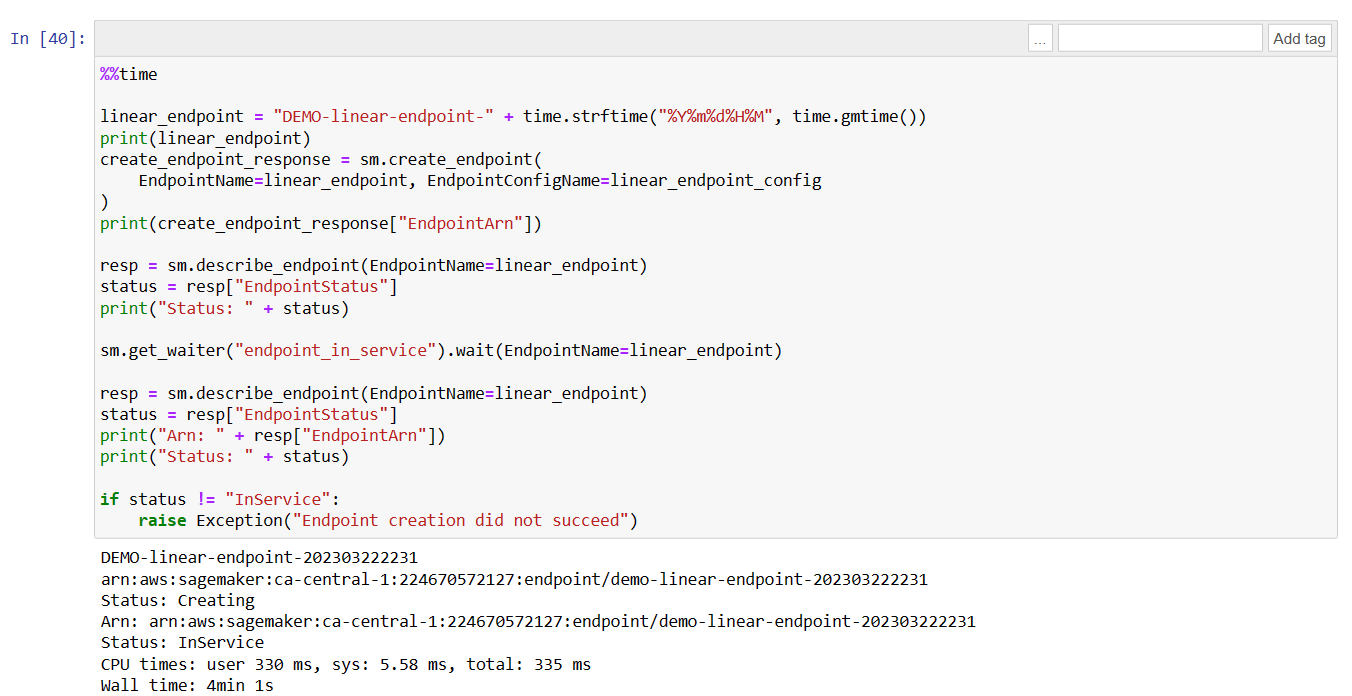

- When we compare serverless with real time, it is noticed that the serverless wall time, cpu time, sys time, and total of it  is much less than the real time.

- When searched it came to noticed that Serverless inference is often faster than real-time inference because serverless architectures can leverage elastic compute resources that can scale automatically based on demand.

- In traditional real-time inference, a fixed amount of compute resources are allocated to handle incoming requests. If the number of requests exceeds the capacity of the allocated resources, it can lead to bottlenecks, slow response times, or even service downtime. Additionally, it can be challenging to predict the exact number of requests at any given time, which means that either overprovisioning or underprovisioning of resources is a possibility.

- Serverless inference, on the other hand, allows for automatic scaling of compute resources based on demand. The infrastructure automatically allocates resources to handle incoming requests, and as the number of requests increases, additional resources are added to ensure that the service can handle the load without any downtime or performance degradation. This on-demand scaling ensures that the required compute resources are always available to handle incoming requests, which can lead to faster and more consistent response times.

- Another factor that can contribute to the faster performance of serverless inference is the ability to cache results. Since serverless functions are stateless, they can quickly return cached results for frequently requested data. This can further reduce the overall response time and improve the performance of the service.

- Overall, serverless inference can be faster than real-time inference because of its ability to dynamically allocate compute resources and cache results. These advantages can lead to improved performance, faster response times, and better scalability.

# Answer 2
-  Use the above cell to re-send an inferencing request to the serverless endpoint immidiately after the first request. Do you see an improvmen in the wall time. If yes why?

In [25]:
%%time
response = runtime.invoke_endpoint(
    EndpointName=endpoint_name,
    Body=b".345,0.224414,.131102,0.042329,.279923,-0.110329,-0.099358,0.0",
    ContentType="text/csv",
)

print(response["Body"].read())

b'4.566554546356201'
CPU times: user 0 ns, sys: 3.81 ms, total: 3.81 ms
Wall time: 71.2 ms


- After second inferencing request is sent to a serverless endpoint immediately after the first request, it was seen an improvement in wall time due to the serverless endpoint's ability to reuse some of the resources that were allocated for the first request.

- I think this is because when a serverless function is invoked, the infrastructure automatically provisions the required compute resources to handle the request. These resources may include CPU, memory, and network bandwidth. When the request is completed, the infrastructure deallocates the resources, making them available for other requests.

- If a second request is sent to the same serverless endpoint immediately after the first request, the infrastructure may reuse some of the resources that were allocated for the first request. For example, if the second request has similar compute requirements as the first request, the infrastructure may reuse the same container that was created for the first request. This can result in a faster response time for the second request since the container is already warm and does not need to be cold-started.

- However, it's important to note that this improvement in response time may be limited by the concurrency limits set on the serverless endpoint. If the second request is sent while the first request is still being processed, the infrastructure may need to provision additional compute resources to handle the second request, which can lead to a longer response time.

- In summary, sending a second inferencing request to a serverless endpoint immediately after the first request can lead to an improvement in wall time due to the potential reuse of resources, but this improvement may be limited by concurrency limits and other factors.

## Please delete the endpoint in the console before you close this session